In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '{:.10f}'.format(x)) #Limiting floats output to 3 decimal points

In [2]:
import os
wd = "D:\RITESH\Data Science\GIT WD\KAGGLE - Home-Credit-Default-Risk"

# Set working directory
os.chdir(wd)


In [3]:
df = pd.read_csv("Output/application_eda_train_clean_new.csv") 

In [4]:
log_cols = df.filter(like='log').columns.tolist()

In [5]:
# Remove log columns by doing antilog of the data to reflect actual dataframe and clean dataframe

lst = []
for i in log_cols:
    lst.append(i[:-4])
    
    
for i in range(len(log_cols)):
    df[lst[i]] = np.exp(df[log_cols[i]])

df.drop(log_cols,axis=1,inplace=True)    

In [ ]:
# Concentration Risk - Exposure to any one industry
# Institutional risk - Institutional risk is the risk associated with the breakdown of the legal structure or of the entity that supervises the contract between the lender and the debtor
# 

#### Divide the dataset into defaulters and non defaulters

In [6]:
df_nd = df.loc[df.TARGET==0]
df_d = df.loc[df.TARGET==1]

In [6]:
df['CREDIT_INCOME_ratio'] = df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']

In [ ]:
df.head()

In [ ]:
df.NAME_INCOME_TYPE.value_counts()

#### HYP:1 What is the loan to income ratio for defaulters as well as non defaulters and is there any significant difference between them

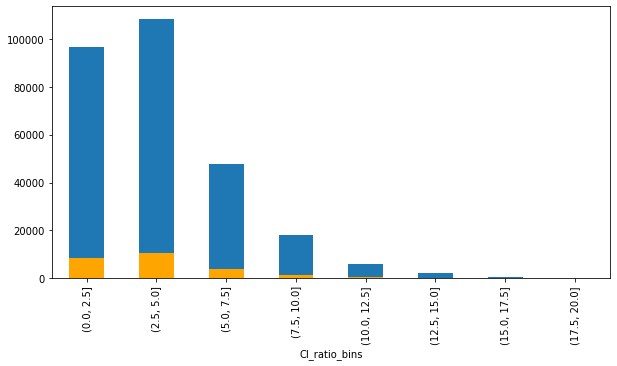

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


bins = pd.IntervalIndex.from_tuples([(0.0, 2.5), 
                                     (2.5, 5.0), 
                                     (5.0, 7.5), 
                                     (7.5, 10.0), 
                                     (10.0, 12.5), 
                                     (12.5, 15.0), 
                                     (15.0, 17.5), 
                                     (17.5, 20.0)])


df_new = pd.DataFrame()
df_new['CI_ratio_bins'] = pd.cut(df.CREDIT_INCOME_ratio, bins)
df_new['CREDIT_INCOME_ratio'] = df.CREDIT_INCOME_ratio
df_new['TARGET'] = df.TARGET

sample_1 = df_new.loc[df_new.TARGET==1]
sample_0 = df_new.loc[df_new.TARGET==0]


plt.figure(figsize=(10,5))
sample_0.groupby('CI_ratio_bins').count()['CREDIT_INCOME_ratio'].plot.bar()
sample_1.groupby('CI_ratio_bins').count()['CREDIT_INCOME_ratio'].plot.bar(color='orange')
plt.xticks(rotation = 'vertical')
plt.show()


In [9]:
df.groupby('TARGET').describe()['CREDIT_INCOME_ratio']

,count,mean,std,min,25%,50%,75%,max
TARGET,,,,,,,,
0,279864.0000000000,3.9656770119,2.6682285801,0.1065650161,2.0212423305,3.2857142857,5.1926736167,47.5539133370
1,24667.0000000000,3.8834501948,2.5647843591,0.1886666667,2.1336000000,3.2601600000,4.9916666667,46.6582298847


#### With the initial look we are unable to differentiate the defaulters from non defaulters based on this parameter.  
#### HYPOTHESIS TESTING:
Null Hypothesis : µ1 = µ2

Alternate Hypothesis : µ1 != µ2

Two Independent samples : 1. non defaulters' credit to income ratio , 2. defaulters' credit to income ratio

Z test : As both the samples > 30

Pooled Variance is assumed to be equal: It doesnt matter whether the loan is defaulted or not the amount of credit and Income and hence no dispersion would be differenciated on the basis of outcome of the application.

In [14]:
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_ind
def ttest_cat_cont_var(df, feature1, feature2):
    sample_0 = np.array(df.loc[df[feature1]==0, feature2].dropna())
    sample_1 = np.array(df.loc[df[feature1]==1, feature2])

    test_stat, pval, _ = stests.ttest_ind(sample_0, sample_1,usevar='unequal')
    test_stat_eq, pval_eq, _ = stests.ttest_ind(sample_0, sample_1,usevar='pooled')

    print("Two independent samples with equal sample size and unequal variances")
    print("test_statistic :{:.3f}".format(test_stat_eq))
    print("p-value :{:.3f}".format(pval_eq))

    print("\nTwo independent samples with unequal sample size and unequal variances")
    print("test_statistic :{:.3f}".format(test_stat))
    print("p-value :{:.3f}".format(pval))

    # Decision Making
    print('-------------------------------------')
    alpha = 0.05
    if pval_eq<=alpha:
        print("Reject H0,There is a statistical evidence of relationship between {} and {} variables".format(feature1,feature2))
    else:
        print("Retain H0,There is no statistical evidence of relationship between {} and {} variables".format(feature1,feature2))

In [11]:
ttest_cat_cont_var(df,'TARGET','AMT_CREDIT')

Two independent samples with equal sample size and unequal variances
test_statistic :16.751
p-value :0.000

Two independent samples with unequal sample size and unequal variances
test_statistic :19.156
p-value :0.000
-------------------------------------
Reject H0,There is a statistical evidence of relationship between TARGET and AMT_CREDIT variables


#### There exists a significant difference between the CREDIT to INCOME ratio between defaulters and non defaulters

#### HYP:1 Does Gender for defaulters as well as non defaulters have any significant difference between them

In [15]:
from scipy.stats import chi2,chi2_contingency
def chi_square_test(df,feature1,feature2):
    contingency_table=pd.crosstab(df[feature1],df[feature2])
    print('contingency_table :-\n',contingency_table)

    #Observed Values
    Observed_Values = contingency_table.values 
    print("Observed Values :-\n",Observed_Values)
    b=chi2_contingency(contingency_table)
    print('Chi2_contingency:\n',b)

    # Expected Values
    Expected_Values = b[3]
    print("Expected Values :-\n",Expected_Values)


    no_of_rows=len(contingency_table.iloc[0:2,0])
    no_of_columns=len(contingency_table.iloc[0,0:2])
    ddof=(no_of_rows-1)*(no_of_columns-1)
    alpha = 0.05

    chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    critical_value=chi2.ppf(q=1-alpha,df=ddof)

    #p-value
    p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)

    # Print all Parameters
    print('-------------------------------------')
    print('p-value:',p_value)
    print('Significance level: ',alpha)
    print('Degree of Freedom: ',ddof)
    print('chi-square statistic:',chi_square_statistic)
    print('critical_value:',critical_value)
    print('p-value:',p_value)


    # Decision Making
    print('-------------------------------------')
    if chi_square_statistic>=critical_value:
        print("Reject H0,There is a relationship between 2 categorical variables")
    else:
        print("Retain H0,There is no relationship between 2 categorical variables")

    if p_value<=alpha:
        print("Reject H0,There is a relationship between 2 categorical variables")
    else:
        print("Retain H0,There is no relationship between 2 categorical variables")

In [13]:
chi_square_test(df,'TARGET','FLAG_WORK_PHONE')

contingency_table :-
 FLAG_WORK_PHONE       0      1
TARGET                        
0                224909  54955
1                 18798   5869
Observed Values :-
 [[224909  54955]
 [ 18798   5869]]
Chi2_contingency:
 (244.77496199186677, 3.577605266448643e-55, 1, array([[223966.74180297,  55897.25819703],
       [ 19740.25819703,   4926.74180297]]))
Expected Values :-
 [[223966.74180297  55897.25819703]
 [ 19740.25819703   4926.74180297]]
-------------------------------------
p-value: 0.0
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 245.03494373766
critical_value: 3.841458820694124
p-value: 0.0
-------------------------------------
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There is a relationship between 2 categorical variables


In [7]:
import Model.FunctionLib as f

In [12]:
stats_df = f.feature_stats(df)

KeyboardInterrupt: 

In [16]:
num, cat = f.distinct_feats(df)
num.remove('SK_ID_CURR')
num.remove('TARGET')

tstat = {}
tdic = {}
pdic = {}

for feat in df.columns:
    if feat in num:
        t, p, _,_ = ttest_cat_cont_var(df,'TARGET',feat)
    else:
        t,p = chi_square_test(df,'TARGET',feat)

    tdic[feat]=t
    pdic[feat]=p

tstat['T-statistic'] = tdic
tstat['P-Value'] = pdic


contingency_table :-
 SK_ID_CURR  100002  100003  100004  100006  100007  100008  100009  100010  \
TARGET                                                                       
0                0       1       1       1       1       1       1       1   
1                1       0       0       0       0       0       0       0   

SK_ID_CURR  100011  100012  ...  456245  456246  456247  456248  456249  \
TARGET                      ...                                           
0                1       1  ...       1       1       1       1       1   
1                0       0  ...       0       0       0       0       0   

SK_ID_CURR  456251  456252  456253  456254  456255  
TARGET                                              
0                1       1       1       0       1  
1                0       0       0       1       0  

[2 rows x 304531 columns]
Observed Values :-
 [[0 1 1 ... 1 0 1]
 [1 0 0 ... 0 1 0]]
Chi2_contingency:
 (304530.9999999999, 0.4991480224698976, 304530,

TypeError: cannot unpack non-iterable NoneType object

In [19]:
df.loc[df['TARGET']==0, 'AMT_ANNUITY'].dropna()

0        37458.000
1        28440.000
2        67500.000
3        16263.000
4        18891.000
            ...   
304525   38700.000
304526   29322.000
304527   41800.500
304528   18382.500
304529   47196.000
Name: AMT_ANNUITY, Length: 279864, dtype: float64

In [17]:
df.isna().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
CREDIT_INCOME_ratio           0
Length: 123, dtype: int64